In [1]:
from scipy.io import loadmat
from matplotlib import pyplot as plt
import numpy as np
from os.path import basename
import shutil
import random
import os
import h5py
from PIL import Image
import pandas as pd
from glob import glob
import pickle

import caffe
from pydensecrf import densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, softmax_to_unary
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# CLOTHING CO-PARSING DATASET 

## OVERVIEW

In [2]:
## reading annotations for 0001.jps
t = loadmat('../annotations/pixel-level/0001.mat')
t

{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Aug 19 15:20:27 2014',
 '__version__': '1.0',
 'groundtruth': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

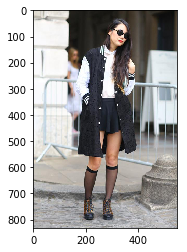

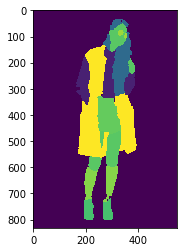

In [3]:
## sample feature image and its corresponding annotations
q = Image.open('../preserves/photos/0001.jpg')
plt.clf()
plt.imshow(q)
plt.show()
plt.clf()
plt.imshow(t['groundtruth'])
plt.show()

## DATASET PREPARATION

In [ ]:
## reading names of categories in the ccp dataset and saving it as csv
labels = loadmat('../label_list.mat')
ccp_categories = []
for i in labels['label_list'][0]:
    ccp_categories.append(str(i[0]))
pd.Series(ccp_categories).to_csv('../color_map.csv')
## manually added RGB colors to each row of this csv

In [ ]:
## create a color palette using RGB values
color_map = pd.read_csv('../color_map.csv', header=None)
color_map.columns = ['index','category','R','G','B']
color_map['color'] = color_map[['R','G','B']].apply(lambda x: str(x['R']) + " " + str(x['G'])+ " " + str(x['B']), axis=1
palette = color_map[['R','G','B']].values
palette = palette.reshape((59*3))
palette = list(palette)

In [ ]:
## read all image annotations and create paletted images using them
annotations = glob('../annotations/pixel-level/*.mat')
for f in annotations:
    gt = loadmat(f)['groundtruth']
    im = Image.fromarray(gt)
    im = im.convert('P')
    im.putpalette(palette)
    im_new = im.convert(mode='RGB')
    im_path = '../labels/' + basename(f).split('.')[0] + '.png'
    im_new.save(im_path, format='PNG')

In [ ]:
## saving RGB values in a csv for caffe to read.
color_map[['R','G','B']].to_csv('../cmap.txt', sep=' ', header=False, index=False)
## caffe requires label names in a seperate csv, against each RGB value
color_map['category'].to_csv('../category_names.txt', index=False, header=False)

In [ ]:
## Re-sizing all feature images and labels, and saving them in th training folder
photos = glob('../preserves/photos/*.jpg')
labels = glob('../preserves/labels/*.png')
photos = photos[:1004]
for i in range(len(photos)):
    fea = Image.open(photos[i])
    fea = fea.resize(size=(500, 800))
    label = Image.open(labels[i])
    label = label.convert('RGB')
    label = label.resize(size=(500,800))
    fea_name = basename(photos[i])
    label_name = basename(labels[i])
    fea.save('../dataset_ccp/train/photos/' + fea_name)
    label.save('../dataset_ccp/train/labels/'+label_name, format='PNG')

In [ ]:
## Moving 200 images and labels from the trainig folder to the test folder
photos = glob('../dataset_ccp/train/photos/*.jpg')
labels = glob('../dataset_ccp/train/labels/*.png')
print len(photos), len(labels)
move_to_test = random.sample(range(len(photos)), 200)
for i in move_to_test:
    shutil.copy(photos[i], '../dataset_ccp/test/photos/')
    shutil.copy(labels[i], '../dataset_ccp/test/labels/')
    os.remove(photos[i])
    os.remove(labels[i])

In [ ]:
## Saving labels in paletted form (P mode), would be required to measure accuracy and iou
labels = glob('../preserves/labels/*.png')
for i in range(len(labels)):
    label = Image.open(labels[i])
    label = label.resize(size=(500,800))
    label_name = basename(labels[i])
    label.save('../dataset_ccp/paletted/'+label_name, format='PNG')

# COLORFUL FASHION PARSING DATASET

## OVERVIEW

[u'#refs#', u'all_category_name', u'all_colors_name', u'fashion_dataset']
[u'category_label', u'color_label', u'img_name', u'segmentation']
50085.jpg name of the corresponding feature image


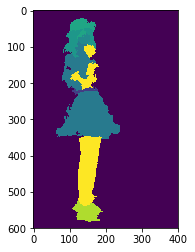

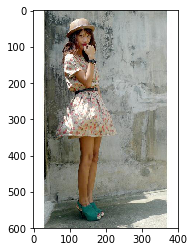

In [16]:
f = h5py.File('../../tmm_dataset_sharing/fashon_parsing_data.mat','r') ## this file contains all annotations
print f.keys()

refs = f.get('#refs#')
fashion_dataset = f.get('fashion_dataset')
fashion_dataset = np.array(fashion_dataset).squeeze()

print refs[fashion_dataset[0]].keys() ## data for 1 image

seg = refs[fashion_dataset[0]]['segmentation'][:] ## contains segmentation data for each pixel in superpixel
cat = refs[fashion_dataset[0]]['category_label'][:].squeeze() ## category label for each superpixel
name = refs[fashion_dataset[0]]['img_name'][:].squeeze() ## image_name
im_name = "".join([chr(v) for v in name])
print im_name , "name of the corresponding feature image"

## create label image
label = []
for row in seg:
    temp = []
    for ele in row:
        temp.append(cat[int(ele)])
    label.append(temp)
label = np.array(label, dtype=int)

plt.clf()
plt.imshow(label.T)
plt.show()

## read and plot feature image
im = Image.open('../../tmm_dataset_sharing/preserves/image/'+im_name)
plt.clf()
plt.imshow(im)
plt.show()

## DATASET PREPARATION

In [ ]:
color_map = pd.read_csv('../../tmm_dataset_sharing/cfpd_categories.csv', header=None)
color_map.columns = ['category','R','G','B']
color_map['color'] = color_map[['R','G','B']].apply(lambda x: str(x['R']) + " " + str(x['G'])+ " " + str(x['B']), axis=1)
palette = color_map[['R','G','B']].values
palette = palette.reshape((23*3))
palette = list(palette)

In [ ]:
color_map[['color']].to_csv('../../tmm_dataset_sharing/cmap.txt', index=False, header=False)
color_map[['category']].to_csv('../../tmm_dataset_sharing/categories_name.txt', index=False, header=False)

In [ ]:
%%time
for i in fashion_dataset:
    group = refs[i]
    cat_label = group['category_label'][:].squeeze()
    segmentation = group['segmentation'][:]
    
    label = []
    for row in segmentation:
        temp = []
        for ele in row:
            temp.append(cat_label[int(ele)]-1)
        label.append(temp)
    
    label = np.asarray(label, dtype=int)
    im = Image.fromarray(label.T).convert('P')
    im.putpalette(palette)
#     im = im.convert('RGB')
    
    im_name = group['img_name'][:].squeeze()[:-4]
    im_name = "".join([chr(v) for v in im_name]) + '.png'
    
    im.save('../../tmm_dataset_sharing/preserves/labels_paletted/'+im_name, format='PNG')

In [ ]:
photos = glob.glob('../../tmm_dataset_sharing/datasets/train/image/*.jpg')
labels = glob.glob('../../tmm_dataset_sharing/datasets/train/labels/*.png')
print len(photos), len(labels)
move_to_test = random.sample(range(len(photos)), 405)
for i in move_to_test:
    shutil.copy(photos[i], '../../tmm_dataset_sharing/datasets/test/image/')
    shutil.copy(labels[i], '../../tmm_dataset_sharing/datasets/test/labels/')
    os.remove(photos[i])
    os.remove(labels[i])

# Caffe and CRF

#### After the datasets were prepared, all the models were trained using DIGITS and were saved to disk. Here I am loading validations sets for evaluating accuarcy and iou. Also implementing CRF post processing for refinement, and to measure its impact on our metrics.

In [ ]:
## caffe uses a series of transformations on data before feeding it into the neural networks
## creating a transformer for all such operations - channel swap, mean subtraction etc.
def getTransformer(net, mean_file_path = None):
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2,0,1))
    transformer.set_channel_swap('data', (2,1,0))
    transformer.set_raw_scale('data', 255)
    if mean_file_path is not None:
        a = caffe.io.caffe_pb2.BlobProto()
        with open(mean_file_path,'rb') as f:
            a.ParseFromString(f.read())
        means = np.asarray(caffe.io.blobproto_to_array(a))[0]
        means = means.mean(1).mean(1)
        transformer.set_mean('data', means)
    return transformer

In [ ]:
## this function runs the forward pass of the given 'net/model' for a given image
## outputs [softmax activations, predicted label image]
def getOutput(inputImagePath, net, transformer, palette):
    im_arr = caffe.io.load_image(inputImagePath)
    x, y, c = im_arr.shape
    net.blobs['data'].reshape(1, c, x, y)
    im_trans = transformer.preprocess('data', im_arr)
    net.blobs['data'].data[...] = im_trans
    layer_name = net.blobs.keys()[-1]
    out = net.forward()[layer_name][0]
    new = np.argmax(out, axis=0)
    new = new.astype('uint8')
    new_im = Image.fromarray(new, 'P')
    new_im.putpalette(palette)
    return out, new_im

## same as the above function
## but only outputs softmax probabilities
def getProba(inputImagePath, net, mean_file_path = None):
    im_arr = caffe.io.load_image(inputImagePath)
    x, y, c = im_arr.shape
    net.blobs['data'].reshape(1, c, x, y)
    transformer = getTransformer(net, mean_file_path)
    im_trans = transformer.preprocess('data', im_arr)
    net.blobs['data'].data[...] = im_trans
    layer_name = net.blobs.keys()[-1]
    out = net.forward()[layer_name][0]
    return out

In [ ]:
#given two matrices, prediction and label, this function outputs accuracy
def accuracy(prediction, truth):
    r = prediction == truth
    return 100.0*r.sum()/(r.shape[0]*r.shape[1]*1.0)

In [ ]:
## this function outputs IOU, given two matrices
def get_IOU(prediction, truth):
    r = (prediction == truth) * (truth > 0)
    intersection = r.sum() * 2.0
    union = (truth != 0).sum() + (prediction != 0).sum()
    return 100*intersection/union

In [ ]:
## CRf
## takes feature image, softmax output of the model, color palette and number of classes as input
## color palette is used to generate the crf processed prediction
## number of classes is same as the number of categories in the classification task
## outputs final images as array and PIL Image form

def crf(image_arr, pred_prob, palette, num_classes):
    softmax = pred_prob.squeeze()
    unary = softmax_to_unary(softmax)
    unary = np.ascontiguousarray(unary)
    d = dcrf.DenseCRF(image_arr.shape[0] * image_arr.shape[1], num_classes)
    d.setUnaryEnergy(unary)
    feats = create_pairwise_gaussian(sdims=(2,2), shape=image_arr.shape[:2])
    bil = create_pairwise_bilateral(sdims=(50,50), schan=(12,12,12), img=image_arr, chdim=2)
    d.addPairwiseEnergy(bil, compat=5)
    d.addPairwiseEnergy(feats, compat=2, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
    Q = d.inference(10)
    res = np.argmax(Q, axis=0).reshape((image_arr.shape[0], image_arr.shape[1]))
    res = np.array(res, dtype=int)
    res_im = Image.fromarray(res)
    res_im = res_im.convert('P')
    res_im.putpalette(palette)
    
    return res, res_im

## Results CCP

In [ ]:
## load trained model
net = caffe.Net('E:/Models/ccp/fcn16s_pretrained_epoch_20.0/deploy.prototxt',
                'E:/Models/ccp/fcn16s_pretrained_epoch_20.0/snapshot_iter_1020.caffemodel',
                caffe.TEST)
mean_proto_path = 'E:/Models/ccp/fcn16s_pretrained_epoch_20.0/mean.binaryproto'

## build transformer
transformer = getTransformer(net, mean_proto_path)

## read color map to build palette
color_map = pd.read_csv('../preserves/color_map.csv', header = None)
color_map.columns = ['i','category', 'R','G','B']
palette = color_map[['R','G','B']].values
palette = palette.reshape((59*3))
palette = list(palette)

In [ ]:
## run forward pass on all validation set images and calculate accuracy and IOU
## Use CRF
## calculate accuracy and IOU over post-processed predictions
## add all the metrics to a table, and save to disk
## also save output images to disk, for future reference

validation_imgs = glob('../dataset_ccp/test/photos/*')
res = []
for img_path in validation_imgs:
    b_name = basename(img_path).split('.')[0]
    label_path = '../dataset_ccp/paletted/' + b_name + '.png'
    
    img_arr = np.asarray(Image.open(img_path))
    truth_arr = np.asarray(Image.open(label_path))
    
    pred_proba, pred = getOutput(img_path, net, transformer, palette)
    pred_arr = np.asarray(pred)

    crf_arr, crf_im = crf(img_arr, pred_proba, palette, 59)
    
    res.append([img_path,
                accuracy(pred_arr, truth_arr),
                get_IOU(pred_arr, truth_arr),
                accuracy(crf_arr, truth_arr),
                get_IOU(crf_arr, truth_arr)])
    
    print b_name
    
    pred.save('E:/Models/out_ccp/pred/' + b_name + '.png', format='PNG')
    crf_im.save('E:/Models/out_ccp/crf/' + b_name + '.png', format='PNG')
    
result = pd.DataFrame.from_records(res, columns=['img','acc','iou','acc_crf','iou_crf'])
result.to_csv('E:/Models/out_ccp/res_ccp_dataframe.csv', index=False)

In [17]:
## reading the file
result_ccp = pd.read_csv('E:/Models/out_ccp/res_ccp_dataframe.csv')
result_ccp.head()

,img,acc,iou,acc_crf,iou_crf
0,../dataset_ccp/test/photos\0005.jpg,78.70175,30.143562,79.8400,32.642104
1,../dataset_ccp/test/photos\0010.jpg,87.29725,38.959549,86.9130,36.805662
2,../dataset_ccp/test/photos\0011.jpg,90.67900,68.417499,91.1765,70.094017
3,../dataset_ccp/test/photos\0015.jpg,84.21250,24.364276,83.3045,18.811974
4,../dataset_ccp/test/photos\0018.jpg,78.45900,7.682138,78.7780,7.726173


In [23]:
print "IOU :", result_ccp.iou.mean(), "\tACC:", result_ccp.acc.mean()
print "IOU WITH CRF:", result_ccp.iou_crf.mean(), "\tACC WITH CRF:", result_ccp.acc_crf.mean()

IOU : 49.7790712409 	ACC: 87.44431875
IOU WITH CRF: 53.4070836848 	ACC WITH CRF: 88.5867275


## Results CFPD

In [ ]:
net = caffe.Net('E:/Models/cfpd/fcns8s_pretrained_epoch_10/deploy.prototxt',
                'E:/Models/cfpd/fcns8s_pretrained_epoch_10/snapshot_iter_5700.caffemodel',
                caffe.TEST)
mean_proto_path = 'E:/Models/cfpd/fcns8s_pretrained_epoch_10/mean.binaryproto'

transformer = getTransformer(net, mean_proto_path)

color_map = pd.read_csv('../../tmm_dataset_sharing/cfpd_categories.csv', header = None)
color_map.columns = ['category', 'R','G','B']
palette = color_map[['R','G','B']].values
palette = palette.reshape((23*3))
palette = list(palette)

In [ ]:
%%time
validation_imgs = glob('../../tmm_dataset_sharing/datasets/test/image/*')
res = []
for img_path in validation_imgs:
    b_name = basename(img_path).split('.')[0]
    label_path = '../../tmm_dataset_sharing/preserves/labels_paletted/' + b_name + '.png'
    
    img_arr = np.asarray(Image.open(img_path))
    truth_arr = np.asarray(Image.open(label_path))
    
    pred_proba, pred = getOutput(img_path, net, transformer, palette)
    pred_arr = np.asarray(pred)

    crf_arr, crf_im = crf(img_arr, pred_proba, palette, 23)
    
    res.append([img_path,
                accuracy(pred_arr, truth_arr),
                get_IOU(pred_arr, truth_arr),
                accuracy(crf_arr, truth_arr),
                get_IOU(crf_arr, truth_arr)])
    
    pred.save('E:/Models/out_cfpd/pred/' + b_name + '.png', format='PNG')
    crf_im.save('E:/Models/out_cfpd/crf/' + b_name + '.png', format='PNG')
    print b_name

result = pd.DataFrame.from_records(res, columns=['img','acc','iou','acc_crf','iou_crf'])
result.to_csv('E:/Models/out_cfpd/res_cfpd_dataframe.csv', index=False)

In [24]:
result_cfpd = pd.read_csv('E:/Models/out_cfpd/res_cfpd_dataframe.csv')
result_cfpd.head()

,img,acc,iou,acc_crf,iou_crf
0,../../tmm_dataset_sharing/datasets/test/image\...,93.160417,66.825872,93.492083,66.602274
1,../../tmm_dataset_sharing/datasets/test/image\...,93.537500,73.656014,94.912083,80.153133
2,../../tmm_dataset_sharing/datasets/test/image\...,93.617917,63.387017,92.636250,56.754666
3,../../tmm_dataset_sharing/datasets/test/image\...,96.025000,80.468946,96.775833,84.929337
4,../../tmm_dataset_sharing/datasets/test/image\...,84.284583,38.982288,88.099167,54.061438


In [25]:
print "IOU :", result_cfpd.iou.mean(), "\tACC:", result_cfpd.acc.mean()
print "IOU WITH CRF:", result_cfpd.iou_crf.mean(), "\tACC WITH CRF:", result_cfpd.acc_crf.mean()

IOU : 67.8286813469 	ACC: 91.9057654321
IOU WITH CRF: 70.0244034126 	ACC WITH CRF: 92.5658919753
